In [1]:
import os
import random
import operator
from collections import Counter
from functools import reduce
from math import factorial

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data_folder = '../data'
data_files = ['ptca_qal.csv', 'ptcp_qal.csv', 'infc_qal_triliteral.csv', 'infa_qal.csv', 'hiphil_triliteral_with_hireq.csv']

In [2]:
def import_mt_data(data_folder, data_file):
    dat = pd.read_csv(os.path.join(data_folder, data_file), sep='\t')
    mt = dat[dat.scroll == 'MT']
    mt = mt[~mt['pattern'].isna()] # remove ketiv/qere
    mt['book2'] = mt.book.str.replace('1_', '').str.replace('2_', '')
    
    if data_file == 'hiphil_triliteral_with_hireq.csv':
        mt = mt[mt.has_hireq == '1'] # remove cases without i-sound

    return mt

In [3]:
def count_permutations(l):
    num = factorial(len(l))
    mults = Counter(l).values()
    den = reduce(operator.mul, (factorial(v) for v in mults), 1)
    return num / den

In [4]:
def make_random_sample(vl_list):
    random.shuffle(vl_list)
    return vl_list

def make_n_grams(sample_list, n):
    n_grams = [tuple(sample_list[k:k+n]) for k, _ in enumerate(sample_list) if k < len(sample_list) - n+1]
    return n_grams

def count_changes(sample_list):
    change_count = 0
    for a, b in sample_list:
        if a != b:
            change_count += 1
    return change_count

def count_alternations(sample_list):
    alternation_count = 0
    for sample in sample_list:
        if sample in {(1, 0, 1, 0), (0, 1, 0, 1)}:
            alternation_count += 1
    return alternation_count

def make_all_samples_for_book_changes(num_samples, book_vowel_letters):
    
    changes = []
    for _ in range(num_samples):
        random_sample = make_random_sample(book_vowel_letters)
        bigrams = make_n_grams(random_sample, 2)
        num_changes = count_changes(bigrams)
        changes.append(num_changes)
    return changes

def make_all_samples_for_book_alternations(num_samples, book_vowel_letters, n):
    
    alternations = []
    for _ in range(num_samples):
        random_sample = make_random_sample(book_vowel_letters)
        n_grams = make_n_grams(random_sample, 4)
        num_alternations = count_alternations(n_grams)
        alternations.append(num_alternations)
    return alternations

In [5]:
def calculate_changes_and_alternations(mt_df, num_samples, min_permutations):
    info_dict = {}
    data_size = 0

    all_books = set(mt_df.book2)
    for book in all_books:
        print(book)
        book_data = mt_df[mt_df.book2 == book]
        book_vl = list(book_data.has_vowel_letter)
        zero_count = book_vl.count(0)
        one_count = book_vl.count(1)
    
        n_permutations = count_permutations(book_vl)

        if n_permutations < min_permutations or one_count < 2 or zero_count < 2:
            continue
        
        data_size += zero_count + one_count 
        fullness = one_count / (zero_count + one_count)
    
        book_vl_copy = book_vl.copy()
        book_samples_changes = make_all_samples_for_book_changes(num_samples, book_vl_copy)
        bigrams = make_n_grams(book_vl, 2)  
        num_changes_book = count_changes(bigrams)
        larger_than_book_changes = sum([1 if change > num_changes_book else 0 for change in book_samples_changes])
    
        book_samples_alternations = make_all_samples_for_book_alternations(num_samples, book_vl_copy, 4)
        trigrams = make_n_grams(book_vl, 4)
        num_alternations_book = count_alternations(trigrams)
        print(num_alternations_book)
        larger_than_book_alternations = sum([1 if alt > num_alternations_book else 0 for alt in book_samples_alternations])

        info = {
            'book': book,
            'zero_count': zero_count,
            'one_count': one_count,
            'num_changes': num_changes_book,
            'larger_than_random_changes': larger_than_book_changes,
            'num_alternations': num_alternations_book,
            'larger_than_random_alternations': larger_than_book_alternations,
            'fullness': fullness,
            'length': zero_count + one_count,
            'fullness_length_interaction': fullness * (zero_count + one_count)
        }
        info_dict[book] = info

    print('data size:', data_size)
    return info_dict

In [6]:
def make_change_df(change_dict):
    df = pd.DataFrame(change_dict).T
    
    cols = ['larger_than_random_changes', 'fullness', 'length', 'fullness_length_interaction']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    return df

In [7]:
# ONLY CHANGES

def make_changes_dotplot(change_df, data_name):
    fig, ax = plt.subplots(figsize=(15, 15))
    sc = sns.scatterplot(data=change_df.sort_values(by='larger_than_random_changes'),
                         x='larger_than_random_changes',
                         y='book',
                         s=200,
                         legend=False,
                         ax=ax,
                         )

    ax.grid(which='major')
    sc.tick_params(labelsize=20)
    sc.set_xlabel('Changes',fontsize=20)
    sc.set_ylabel('',fontsize=20)

    plt.savefig(f'{data_name}_changes_dotplot.png') 
    plt.show()

In [8]:
# RElATIONSHIP FULLNESS AND CHANGES

def make_changes_fullness_scatterplot(change_df, data_name, data_column, analysis_type):
    sns.regplot(data=change_df, 
                y=data_column,
                x='fullness', 
                order=2)
    
    plt.savefig(f'{data_name}_fullness_{analysis_type}_scatterplot.png') 
    plt.show()
    
    
def make_changes_length_scatterplot(change_df, data_name, data_column, analysis_type):    
    sns.regplot(data=change_df, 
                y=data_column,
                x='length',
                #order=2
               )
    
    plt.savefig(f'{data_name}_fullness_{analysis_type}_scatterplot.png') 
    plt.show()

# Import and prepare data: changes

ptca_qal
ptca_qal.csv (4617, 36)
data size: 4609


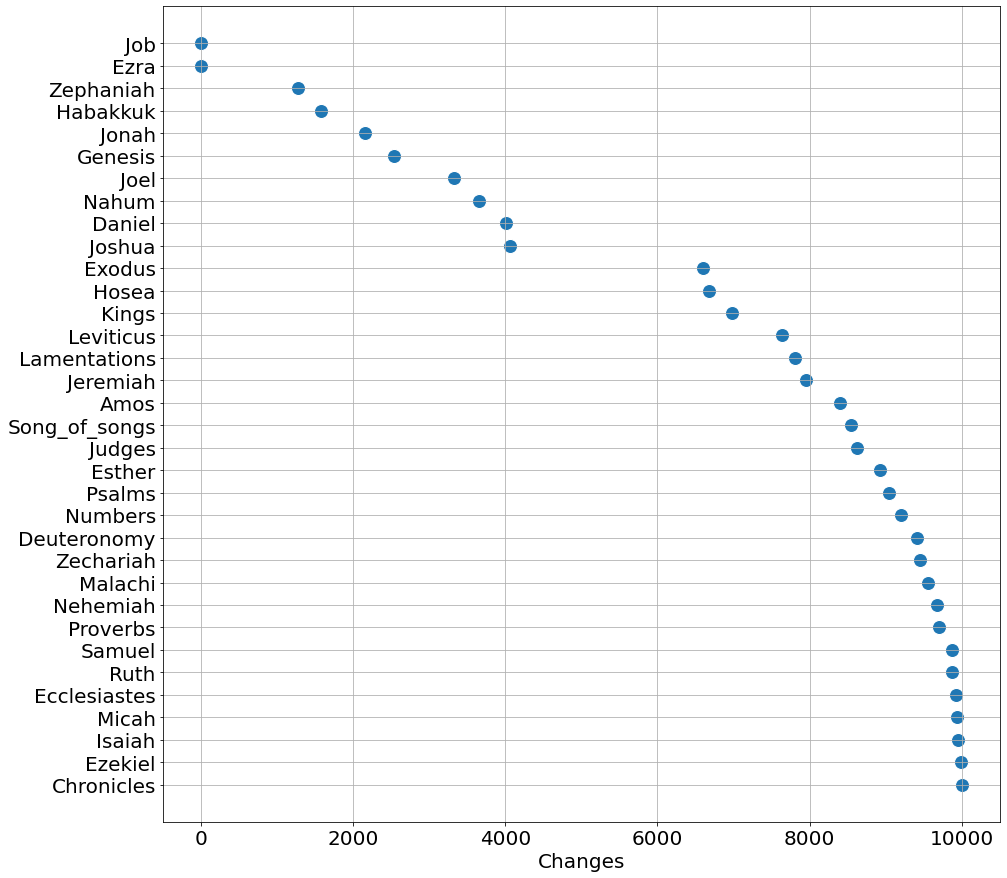

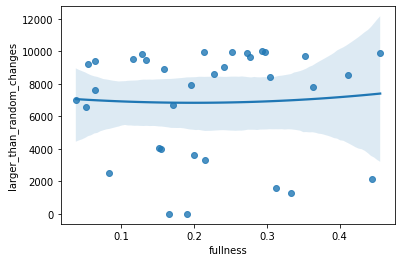

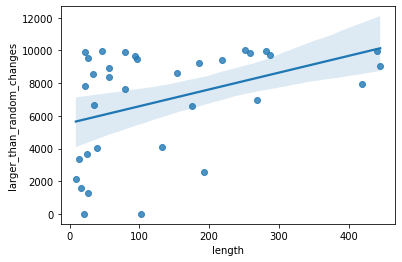

ptcp_qal
ptcp_qal.csv (940, 36)
data size: 834


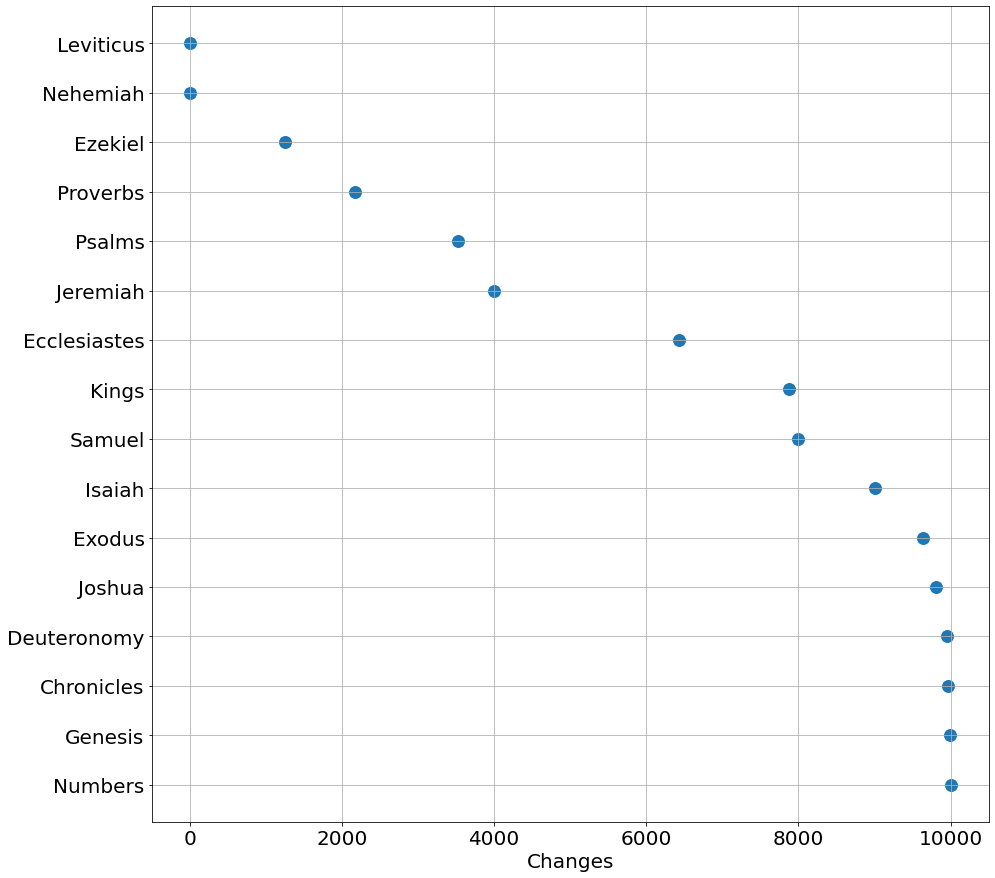

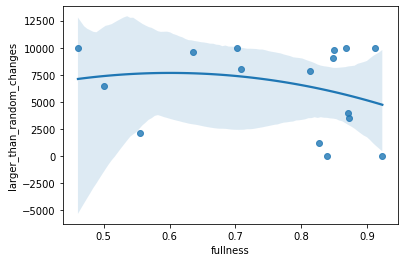

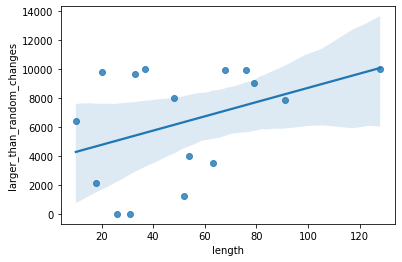

infc_qal_triliteral
infc_qal_triliteral.csv (1826, 36)
data size: 1376


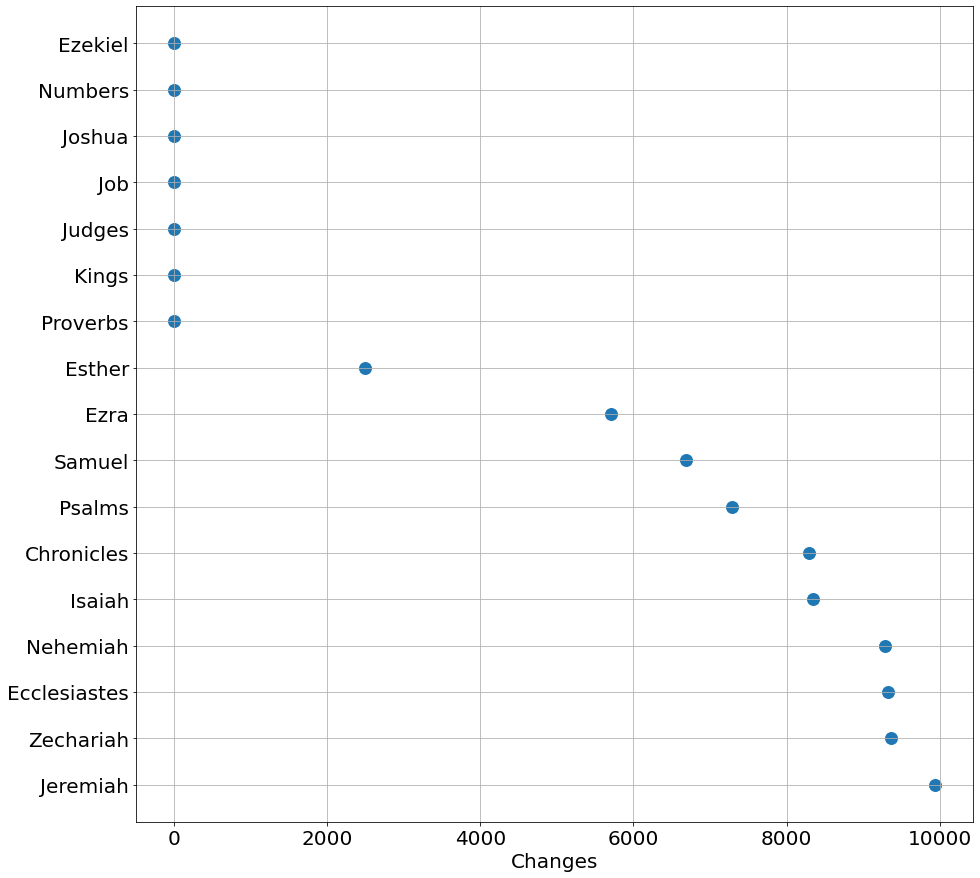

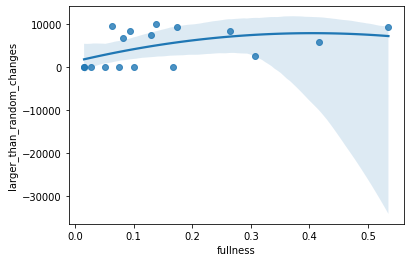

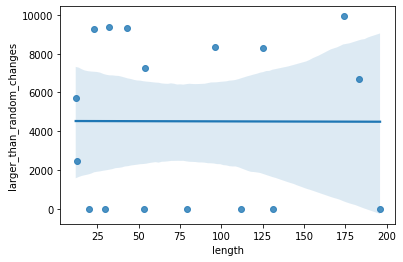

infa_qal
infa_qal.csv (317, 36)
data size: 255


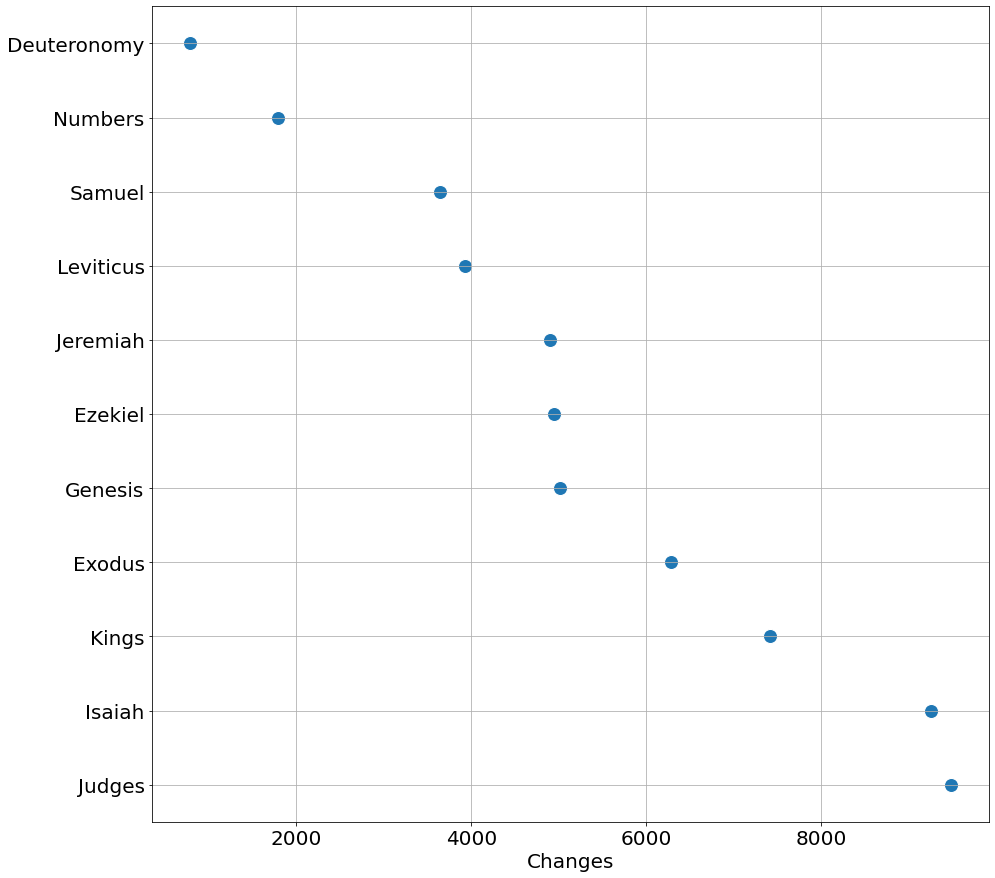

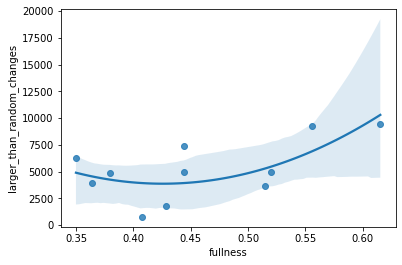

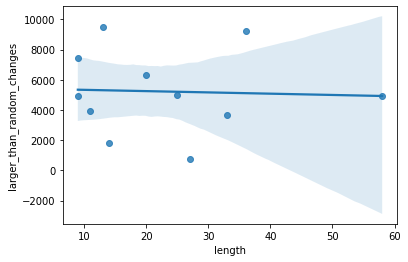

hiphil_triliteral_with_hireq
hiphil_triliteral_with_hireq.csv (2360, 38)
data size: 2177


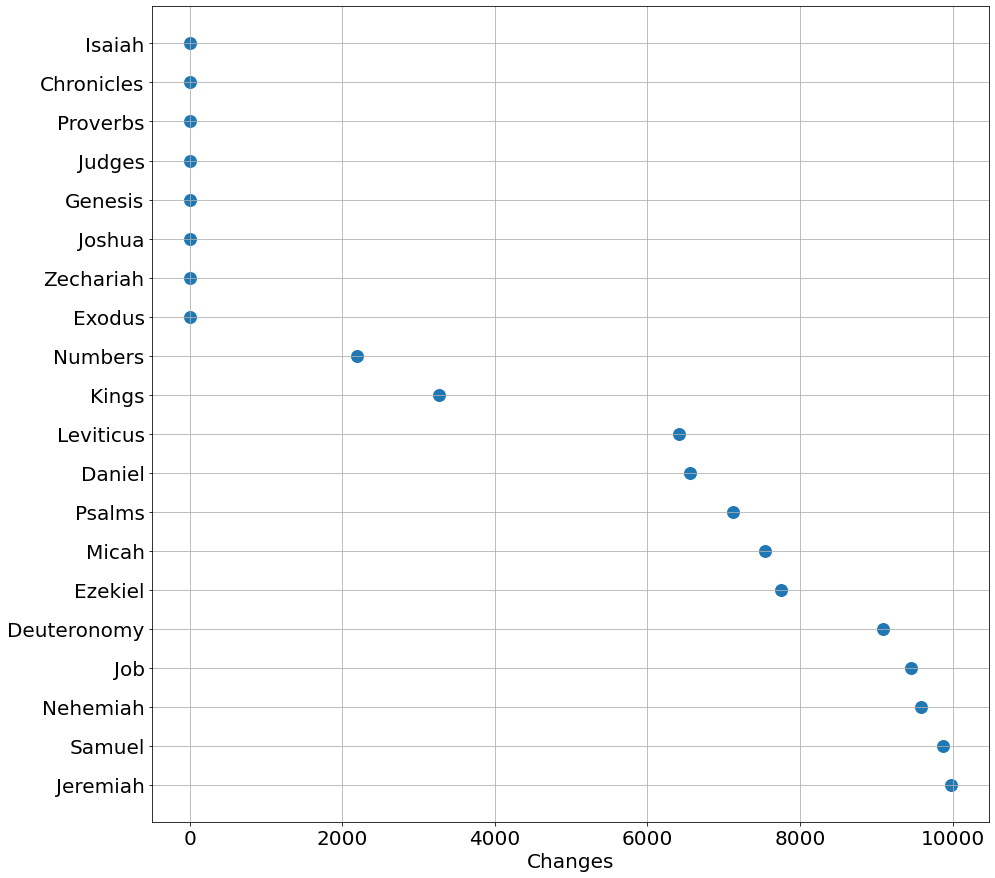

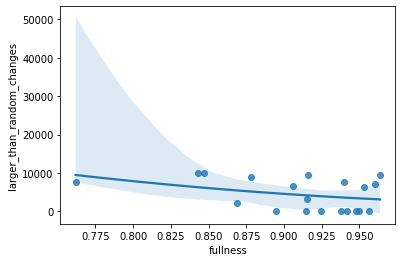

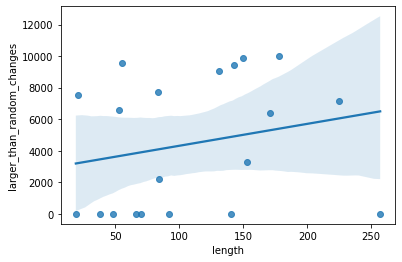

In [49]:
num_samples = 10000
min_permutations = 100

datasets = {}


for data_file in data_files:
    data_name = data_file.split('.')[0]
    print(data_name)
    
    mt_df = import_mt_data(data_folder, data_file)
    datasets[data_name] = mt_df
    change_dict = calculate_changes_and_alternations(mt_df, num_samples, min_permutations)
    change_df = make_change_df(change_dict)
    
    
    # Make and save figures
    make_changes_dotplot(change_df, data_name)
    make_changes_fullness_scatterplot(change_df, data_name, 'change')
    make_changes_length_scatterplot(change_df, data_name, 'change')

 # Process alternations

In [33]:
def make_alternation_df(change_dict):
    df = pd.DataFrame(change_dict).T
    print(df.head())
    cols = ['larger_than_random_alternations', 'fullness', 'length', 'fullness_length_interaction']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    return df

In [34]:
# ONLY CHANGES

def make_alternations_dotplot(change_df, data_name):
    fig, ax = plt.subplots(figsize=(15, 15))
    sc = sns.scatterplot(data=change_df.sort_values(by='larger_than_random_alternations'),
                         x='larger_than_random_alternations',
                         y='book',
                         s=200,
                         legend=False,
                         ax=ax,
                         )

    ax.grid(which='major')
    sc.tick_params(labelsize=20)
    sc.set_xlabel('Changes',fontsize=20)
    sc.set_ylabel('',fontsize=20)

    plt.savefig(f'{data_name}_alternations_dotplot.png') 
    plt.show()

ptca_qal
Isaiah
23
Amos
0
Obadiah
Psalms
25
Genesis
2
Samuel
0
Ezra
0
Jonah
1
Micah
1
Joshua
6
Judges
8
Hosea
0
Lamentations
1
Esther
0
Nahum
2
Jeremiah
27
Joel
0
Ecclesiastes
5
Daniel
0
Numbers
1
Proverbs
18
Song_of_songs
2
Malachi
0
Zechariah
2
Deuteronomy
3
Nehemiah
3
Ruth
0
Zephaniah
8
Job
6
Exodus
2
Leviticus
0
Ezekiel
4
Haggai
Habakkuk
3
Kings
0
Chronicles
2
data size: 4609
            book zero_count one_count num_changes larger_than_random_changes  \
Isaiah    Isaiah        329       111         144                       9957   
Amos        Amos         39        17          20                       8389   
Psalms    Psalms        338       107         152                       8973   
Genesis  Genesis        176        16          30                       2554   
Samuel    Samuel        225        33          49                       9843   

        num_alternations larger_than_random_alternations  fullness length  \
Isaiah                23                            8601  0

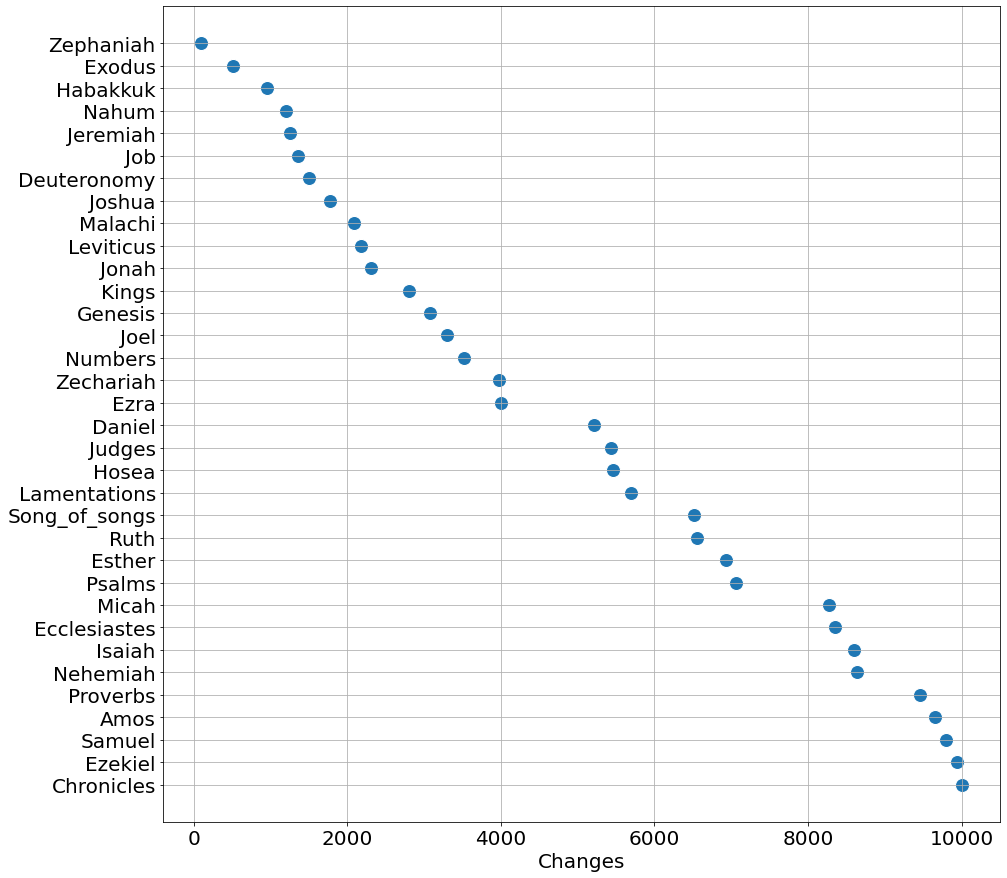

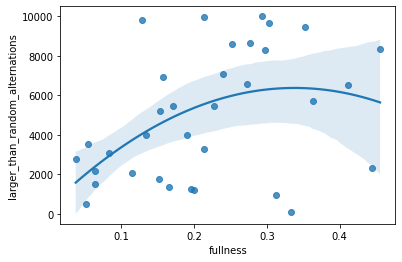

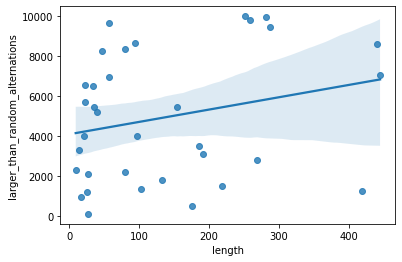

ptcp_qal
Isaiah
0
Amos
Obadiah
Psalms
2
Genesis
0
Samuel
2
Ezra
Jonah
Micah
Joshua
0
Judges
Hosea
Lamentations
Esther
Nahum
Jeremiah
0
Joel
Ecclesiastes
0
Daniel
Numbers
4
Proverbs
1
Song_of_songs
Malachi
Zechariah
Deuteronomy
0
Nehemiah
0
Ruth
Zephaniah
Job
Exodus
1
Leviticus
0
Ezekiel
2
Haggai
Habakkuk
Kings
3
Chronicles
1
data size: 834
            book zero_count one_count num_changes larger_than_random_changes  \
Isaiah    Isaiah         12        67          17                       9027   
Psalms    Psalms          8        55          14                       3574   
Genesis  Genesis         11        26           7                       9988   
Samuel    Samuel         14        34          17                       8088   
Joshua    Joshua          3        17           2                       9819   

        num_alternations larger_than_random_alternations  fullness length  \
Isaiah                 0                            7926  0.848101     79   
Psalms                 

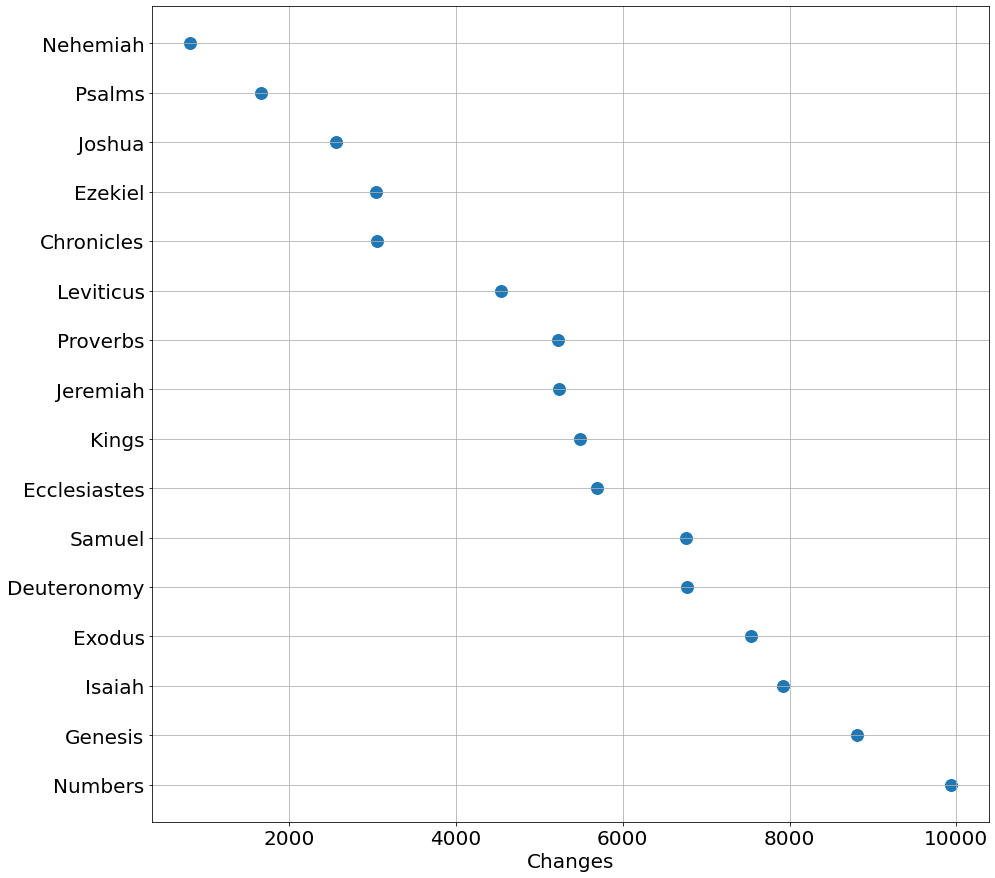

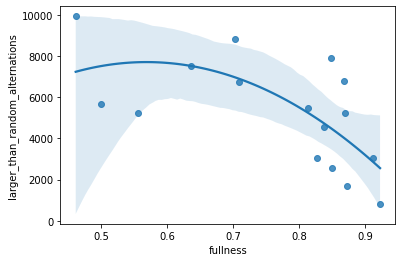

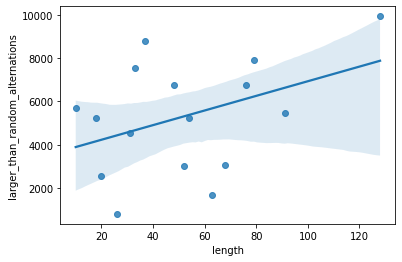

infc_qal_triliteral
Isaiah
1
Amos
Obadiah
Psalms
0
Genesis
Samuel
2
Ezra
0
Jonah
Micah
Joshua
0
Judges
0
Hosea
Lamentations
Esther
0
Jeremiah
3
Joel
Ecclesiastes
2
Daniel
Numbers
0
Proverbs
0
Song_of_songs
Malachi
Zechariah
0
Deuteronomy
Nehemiah
0
Ruth
Zephaniah
Job
0
Exodus
Leviticus
Ezekiel
0
Haggai
Habakkuk
Kings
0
Chronicles
12
data size: 1376
          book zero_count one_count num_changes larger_than_random_changes  \
Isaiah  Isaiah         87         9          14                       8340   
Psalms  Psalms         47         7          11                       7294   
Samuel  Samuel        168        15          26                       6825   
Ezra      Ezra          7         5           5                       5766   
Joshua  Joshua         75         4           8                          0   

       num_alternations larger_than_random_alternations  fullness length  \
Isaiah                1                            4521   0.09375     96   
Psalms                0     

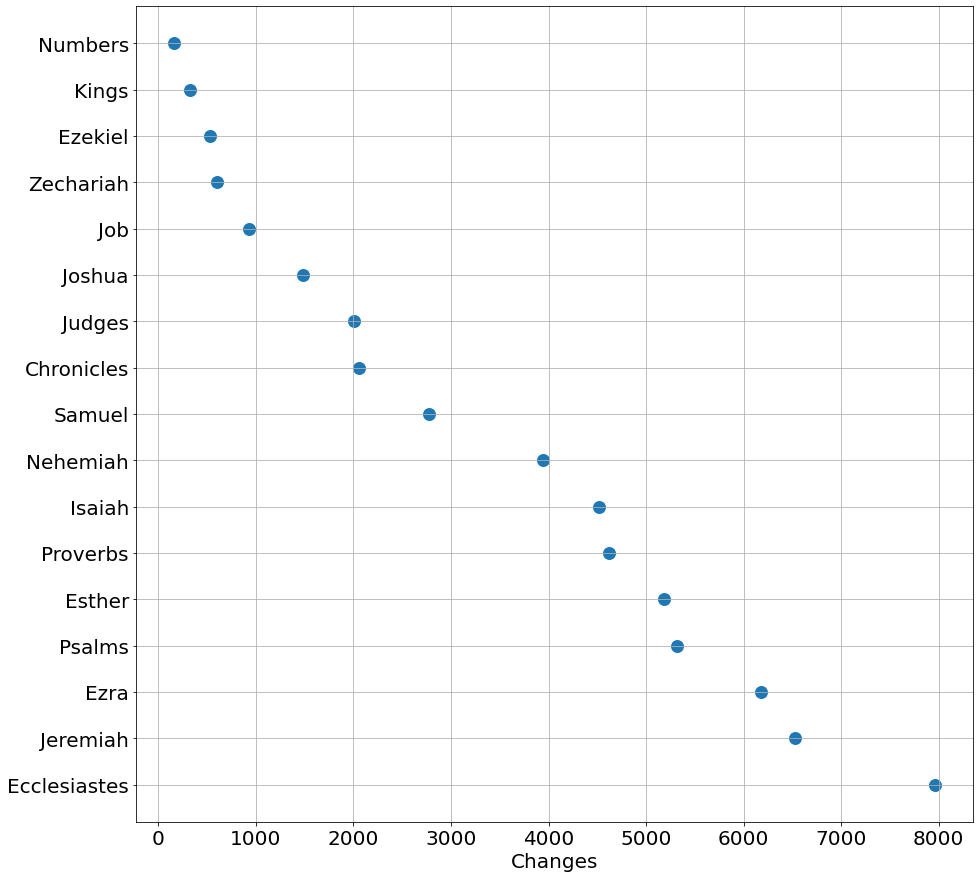

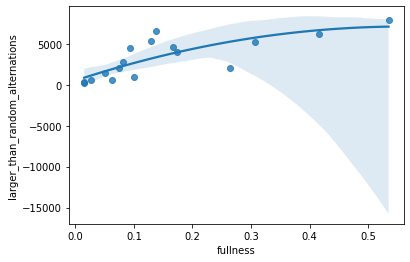

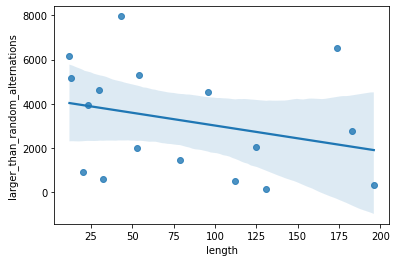

infa_qal
Isaiah
1
Amos
Psalms
Genesis
4
Samuel
4
Micah
Joshua
Judges
0
Hosea
Lamentations
Esther
Nahum
Jeremiah
6
Joel
Ecclesiastes
Numbers
3
Proverbs
Zechariah
Deuteronomy
7
Nehemiah
Zephaniah
Job
Exodus
3
Leviticus
1
Ezekiel
0
Haggai
Kings
1
Chronicles
data size: 255
              book zero_count one_count num_changes  \
Isaiah      Isaiah         16        20          13   
Genesis    Genesis         12        13          12   
Samuel      Samuel         16        17          17   
Judges      Judges          5         8           3   
Jeremiah  Jeremiah         36        22          27   

         larger_than_random_changes num_alternations  \
Isaiah                         9302                1   
Genesis                        5034                4   
Samuel                         3500                4   
Judges                         9426                0   
Jeremiah                       4718                6   

         larger_than_random_alternations  fullness length  \
I

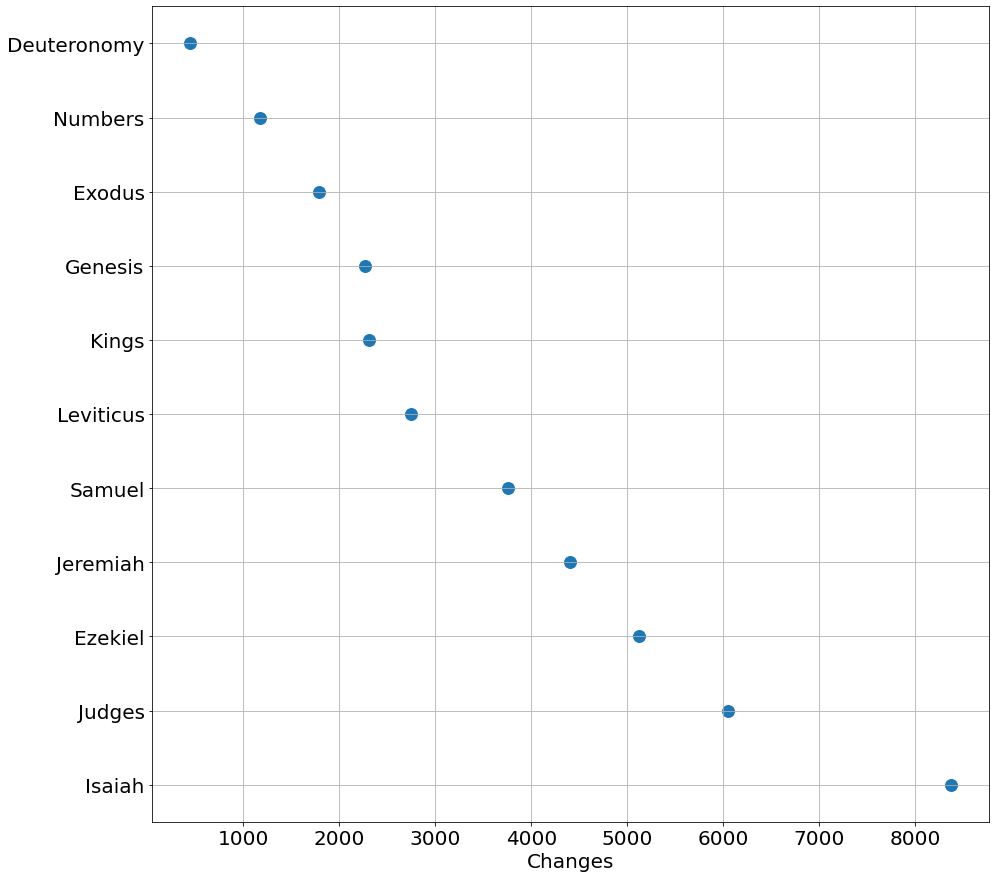

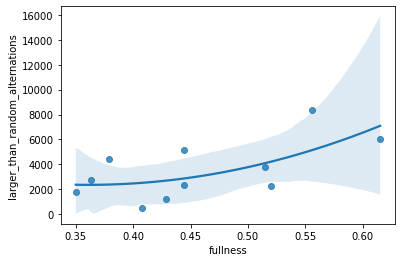

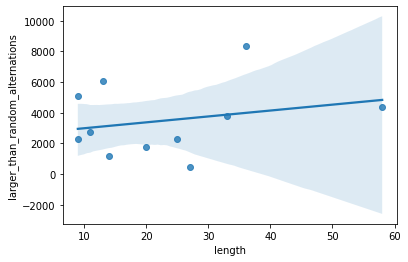

hiphil_triliteral_with_hireq
Isaiah
0
Amos
Obadiah
Psalms
2
Genesis
0
Samuel
1
Ezra
Jonah
Micah
3
Joshua
0
Judges
0
Hosea
Lamentations
Esther
Nahum
Jeremiah
7
Joel
Ecclesiastes
Daniel
0
Numbers
4
Proverbs
0
Song_of_songs
Malachi
Zechariah
0
Deuteronomy
1
Nehemiah
0
Ruth
Zephaniah
Job
1
Exodus
2
Leviticus
0
Ezekiel
1
Haggai
Habakkuk
Kings
2
Chronicles
0
data size: 2177
            book zero_count one_count num_changes larger_than_random_changes  \
Isaiah    Isaiah         15       242          30                          0   
Psalms    Psalms          9       216          16                       7059   
Genesis  Genesis          6        64          12                          0   
Samuel    Samuel         23       127          31                       9884   
Micah      Micah          5        16           6                       7498   

        num_alternations larger_than_random_alternations  fullness length  \
Isaiah                 0                            5431  0.941634    2

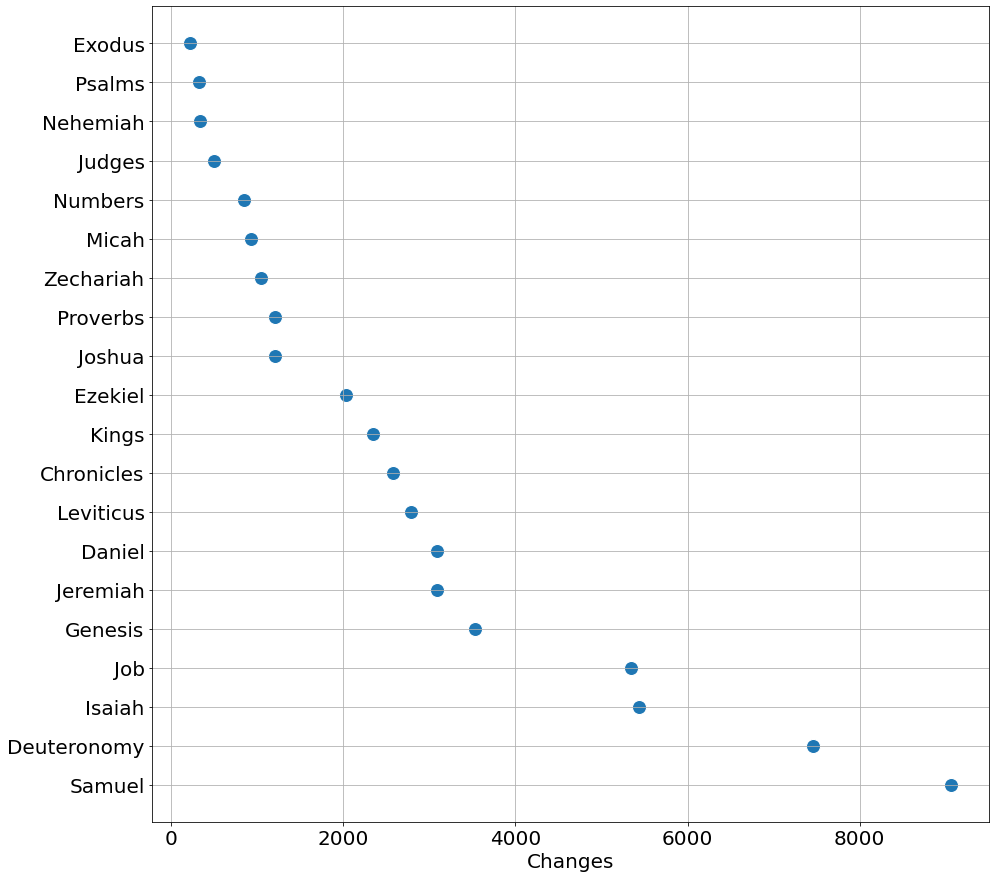

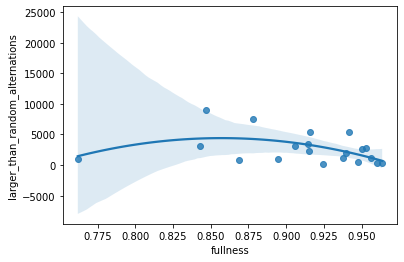

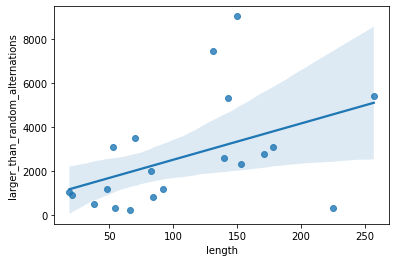

In [35]:
num_samples = 10000
min_permutations = 100

datasets = {}


for data_file in data_files:
    data_name = data_file.split('.')[0]
    print(data_name)
    
    mt_df = import_mt_data(data_folder, data_file)
    datasets[data_name] = mt_df
    change_dict = calculate_changes_and_alternations(mt_df, num_samples, min_permutations)
    change_df = make_alternation_df(change_dict)

    # Make and save figures
    make_alternations_dotplot(change_df, data_name)
    make_changes_fullness_scatterplot(change_df, data_name, 'larger_than_random_alternations', 'alternation')
    make_changes_length_scatterplot(change_df, data_name, 'larger_than_random_alternations', 'alternation')

In [57]:
mt_df

,tf_id,scroll,book,chapter,verse,lex,g_cons,stem,pattern,pattern_g_cons,...,column,has_prs,has_prefix,has_hloc,has_nme,rec_signs_stem,cor_signs_stem,type,vowel_letter,has_vowel_letter
0,976,MT,Genesis,2,16,>KL[,>KL,>KL,CCC,CCC,...,-,0,0,0,0,nnn,nnn,last,NaN,0
1,3598,MT,Genesis,8,3,HLK[,HLWK,HLWK,CCMC,CCMC,...,-,0,0,0,0,nnnn,nnnn,last,W,1
2,3634,MT,Genesis,8,5,HLK[,HLWK,HLWK,CCMC,CCMC,...,-,0,0,0,0,nnnn,nnnn,last,W,1
3,3636,MT,Genesis,8,5,XSR[,XSWR,XSWR,CCMC,CCMC,...,-,0,1,0,0,nnnn,nnnn,last,W,1
4,3676,MT,Genesis,8,7,JY>[,JYW>,JYW>,CCMM,CCMM,...,-,0,0,0,0,nnnn,nnnn,last,W,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,420803,MT,2_Chronicles,28,19,M<L[,M<WL,M<WL,CCMC,CCMC,...,-,0,1,0,0,nnnn,nnnn,last,W,1
315,422780,MT,2_Chronicles,31,10,>KL[,>KWL,>KWL,CCMC,CCMC,...,-,0,0,0,0,nnnn,nnnn,last,W,1
316,422782,MT,2_Chronicles,31,10,FB<[,FBW<,FBW<,CCMC,CCMC,...,-,0,1,0,0,nnnn,nnnn,last,W,1
317,423391,MT,2_Chronicles,32,13,JKL[,JKWL,JKWL,CCMC,CCMC,...,-,0,1,0,0,nnnn,nnnn,last,W,1


In [36]:
dat = datasets['ptca_qal']

book_data = dat[dat.book2 == 'Zephaniah']
book_vl = list(book_data.has_vowel_letter)

chaps = list(book_data.chapter)
verses = list(book_data.verse)
lex = list(book_data.lex)
g_cons = list(book_data.g_cons)
print(book_data.shape, sum(book_vl))

for ch, ve, le, g_c, vl in zip(chaps, verses, lex, g_cons, book_vl):
    print(ch, ve, le, g_c, vl)
    
print(pd.value_counts(book_data.has_vowel_letter))


(27, 36) 9
1 2 >SP[ >SP 0
1 3 >SP[ >SP 0
1 3 >SP[ >SP 0
1 4 JCB[ JWCBJ 1
1 8 LBC[ LBCJM 0
1 9 DLG[ DWLG 1
1 11 JCB[ JCBJ 0
1 12 QP>[ QP>JM 0
1 12 >MR[ >MRJM 0
1 14 YRX[ YRX 0
1 18 JCB[ JCBJ 0
2 5 JCB[ JCBJ 0
2 5 JCB[ JWCB 1
2 6 R<H[ R<JM 0
2 15 JCB[ JWCBT 1
2 15 >MR[ >MRH 0
2 15 <BR[ <WBR 1
3 1 MR>=[ MR>H 0
3 1 JNH[ JWNH 1
3 3 C>G[ C>GJM 0
3 3 CPV[ CPVJH 0
3 4 PXZ[ PXZJM 0
3 5 JD<[ JWD< 1
3 6 <BR[ <WBR 1
3 6 JCB[ JWCB 1
3 19 <FH[ <FH 0
3 19 YL<[ YL<H 0
0    18
1     9
Name: has_vowel_letter, dtype: int64


In [64]:
dat[dat.book2.isin(['Samuel', 'Kings'])].to_csv('qal_infa_sam_kgs.csv', sep='\t')

In [62]:
pd.crosstab(dat.book, dat.has_vowel_letter)

has_vowel_letter,0,1
book,,
1_Chronicles,1,2
1_Kings,4,0
1_Samuel,13,5
2_Chronicles,0,6
2_Kings,1,4
2_Samuel,3,12
Amos,0,1
Deuteronomy,16,11
Ecclesiastes,0,2


In [16]:
count_permutations([1,1,0,0])

6.0

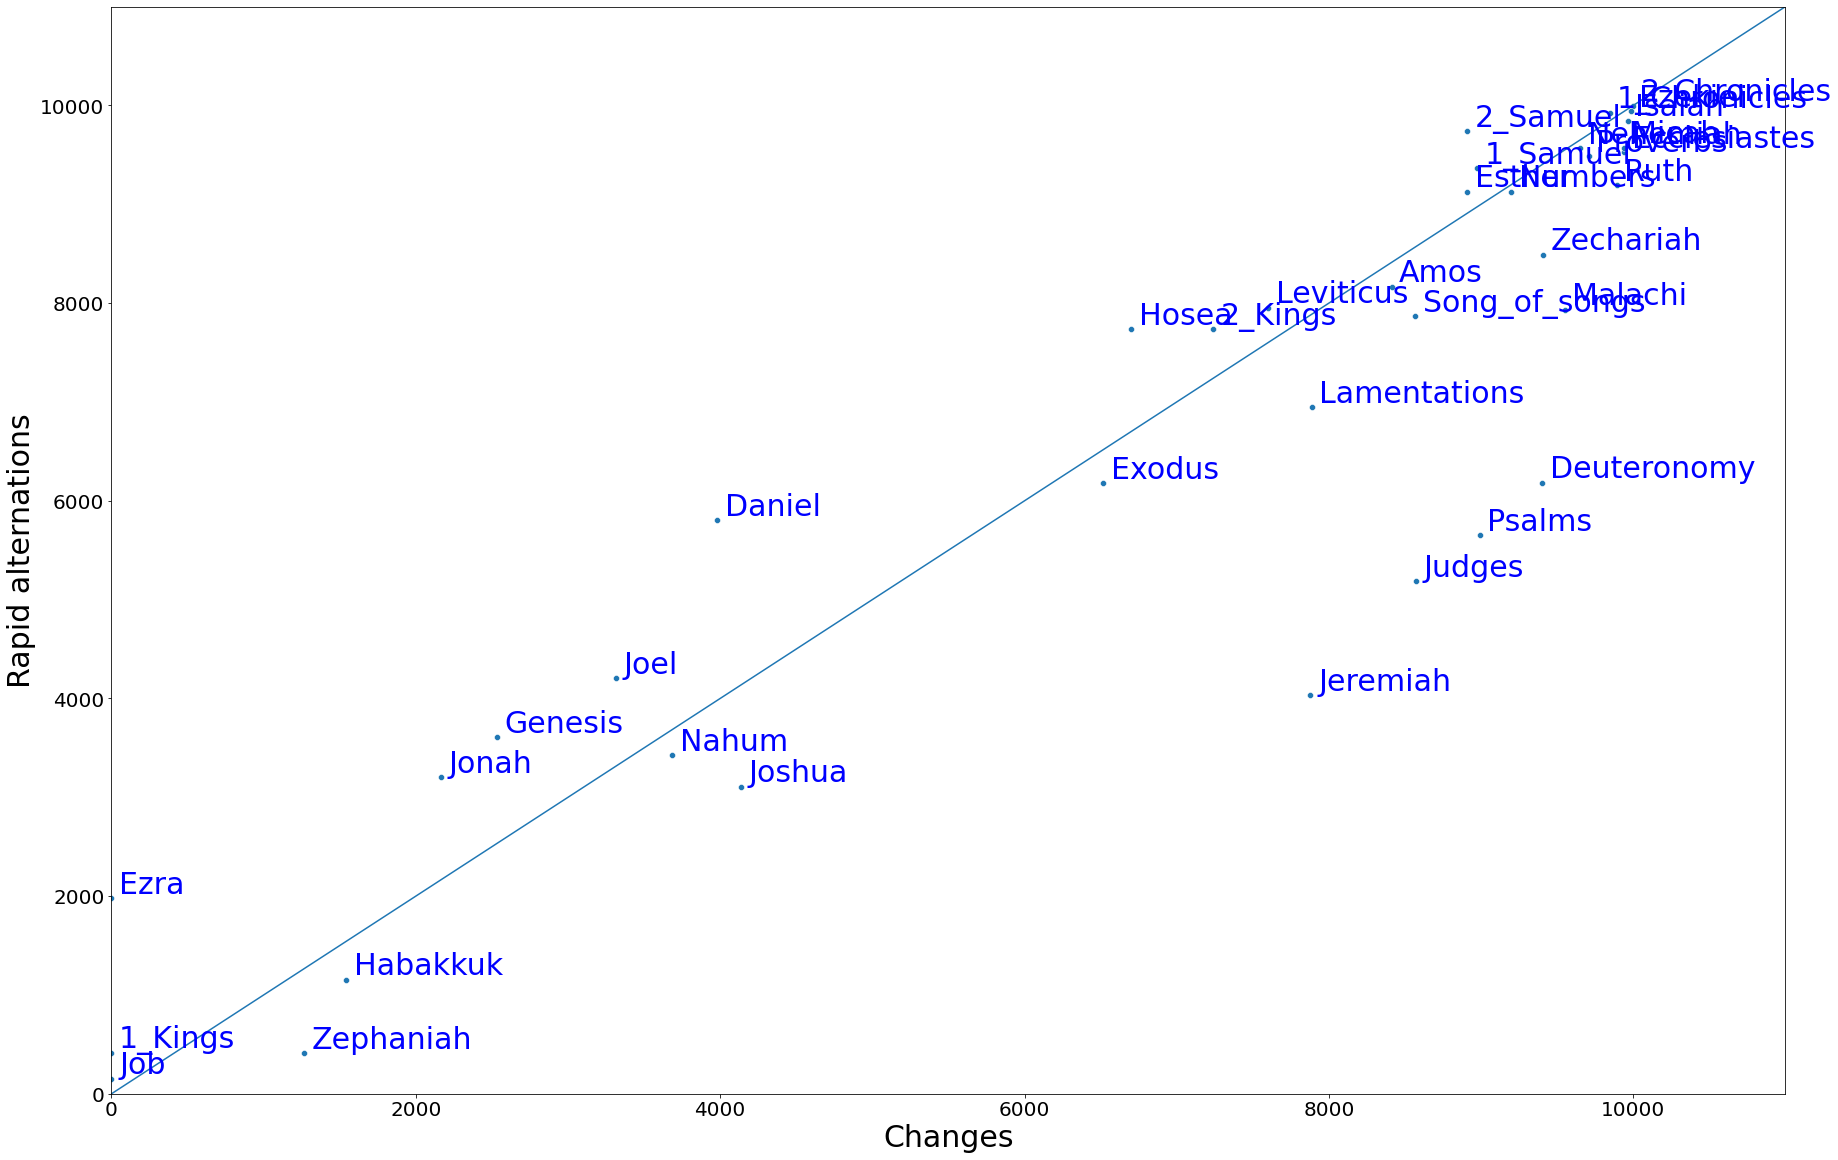

In [10]:
# Changes vs alternations

plt.figure(figsize=(30,20))
plt.xlim([0, 11000])
plt.ylim([0, 11000])

ident = [0.0, 100000]
plt.plot(ident,ident)

sns.scatterplot(data=change_df,x='larger_than_random_changes',y='larger_than_random_alternations')

plt.xlabel('Changes',size=30)
plt.ylabel('Rapid alternations', size=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

for i in range(change_df.shape[0]):
     plt.text(x=change_df.larger_than_random_changes[i]+50,y=change_df.larger_than_random_alternations[i]+50, s=change_df.book[i], 
            fontdict=dict(color='blue',size=30),
            )

plt.savefig(data_file.split('.')[0] + '_scatterplot.png')    
plt.show()

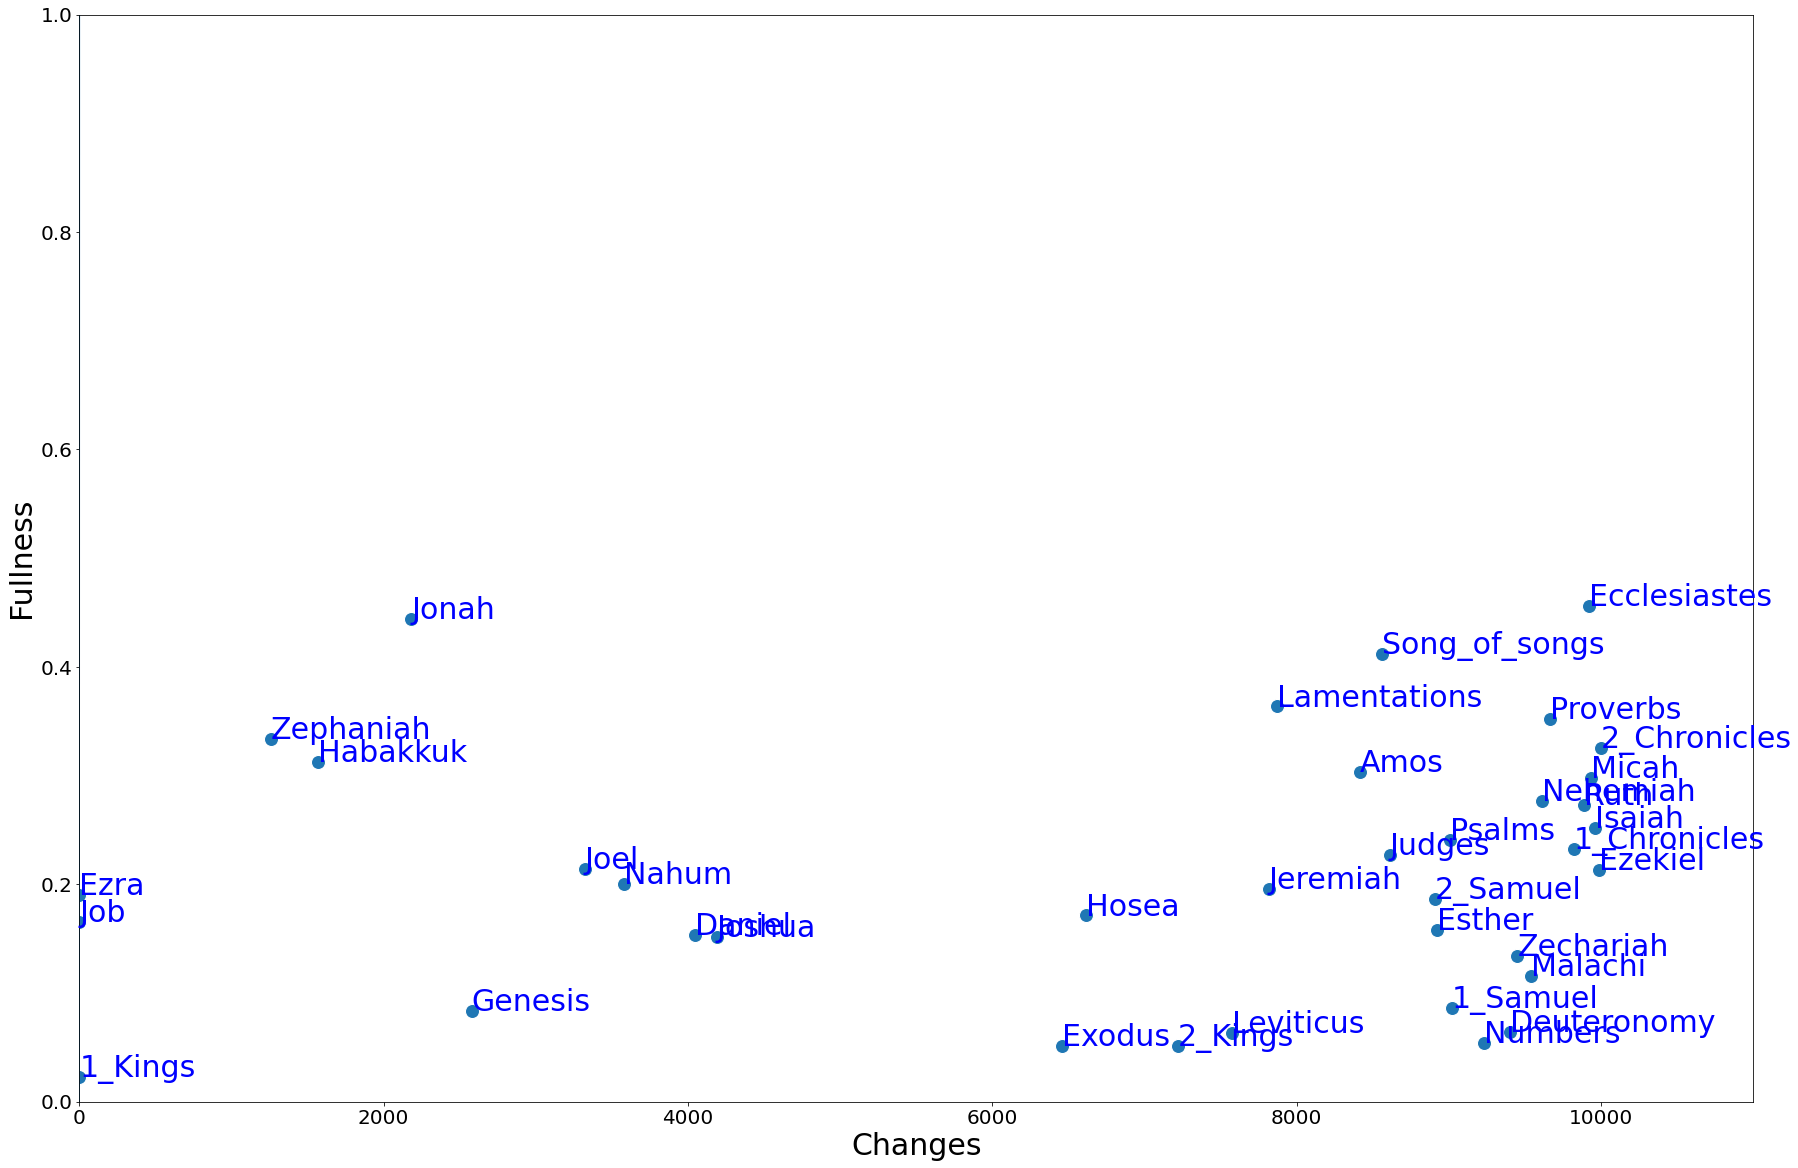

In [44]:
# Changes vs fullness

plt.figure(figsize=(30,20))
plt.xlim([0, 11000])
plt.ylim([0, 1])

ident = [0.0, 100000]
plt.plot(ident,ident)

sns.scatterplot(data=change_df,
                x='larger_than_random_changes',
                y='fullness',
                s=200
               )

plt.xlabel('Changes',size=30)
plt.ylabel('Fullness', size=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

for i in range(change_df.shape[0]):
    plt.text(x=change_df.larger_than_random_changes[i],y=change_df.fullness[i], s=change_df.book[i], 
            fontdict=dict(color='blue',size=30),
            #bbox=dict(facecolor='yellow',alpha=0.5)
            )

#plt.savefig(data_file.split('.')[0] + '_scatterplot.png')    
plt.show()

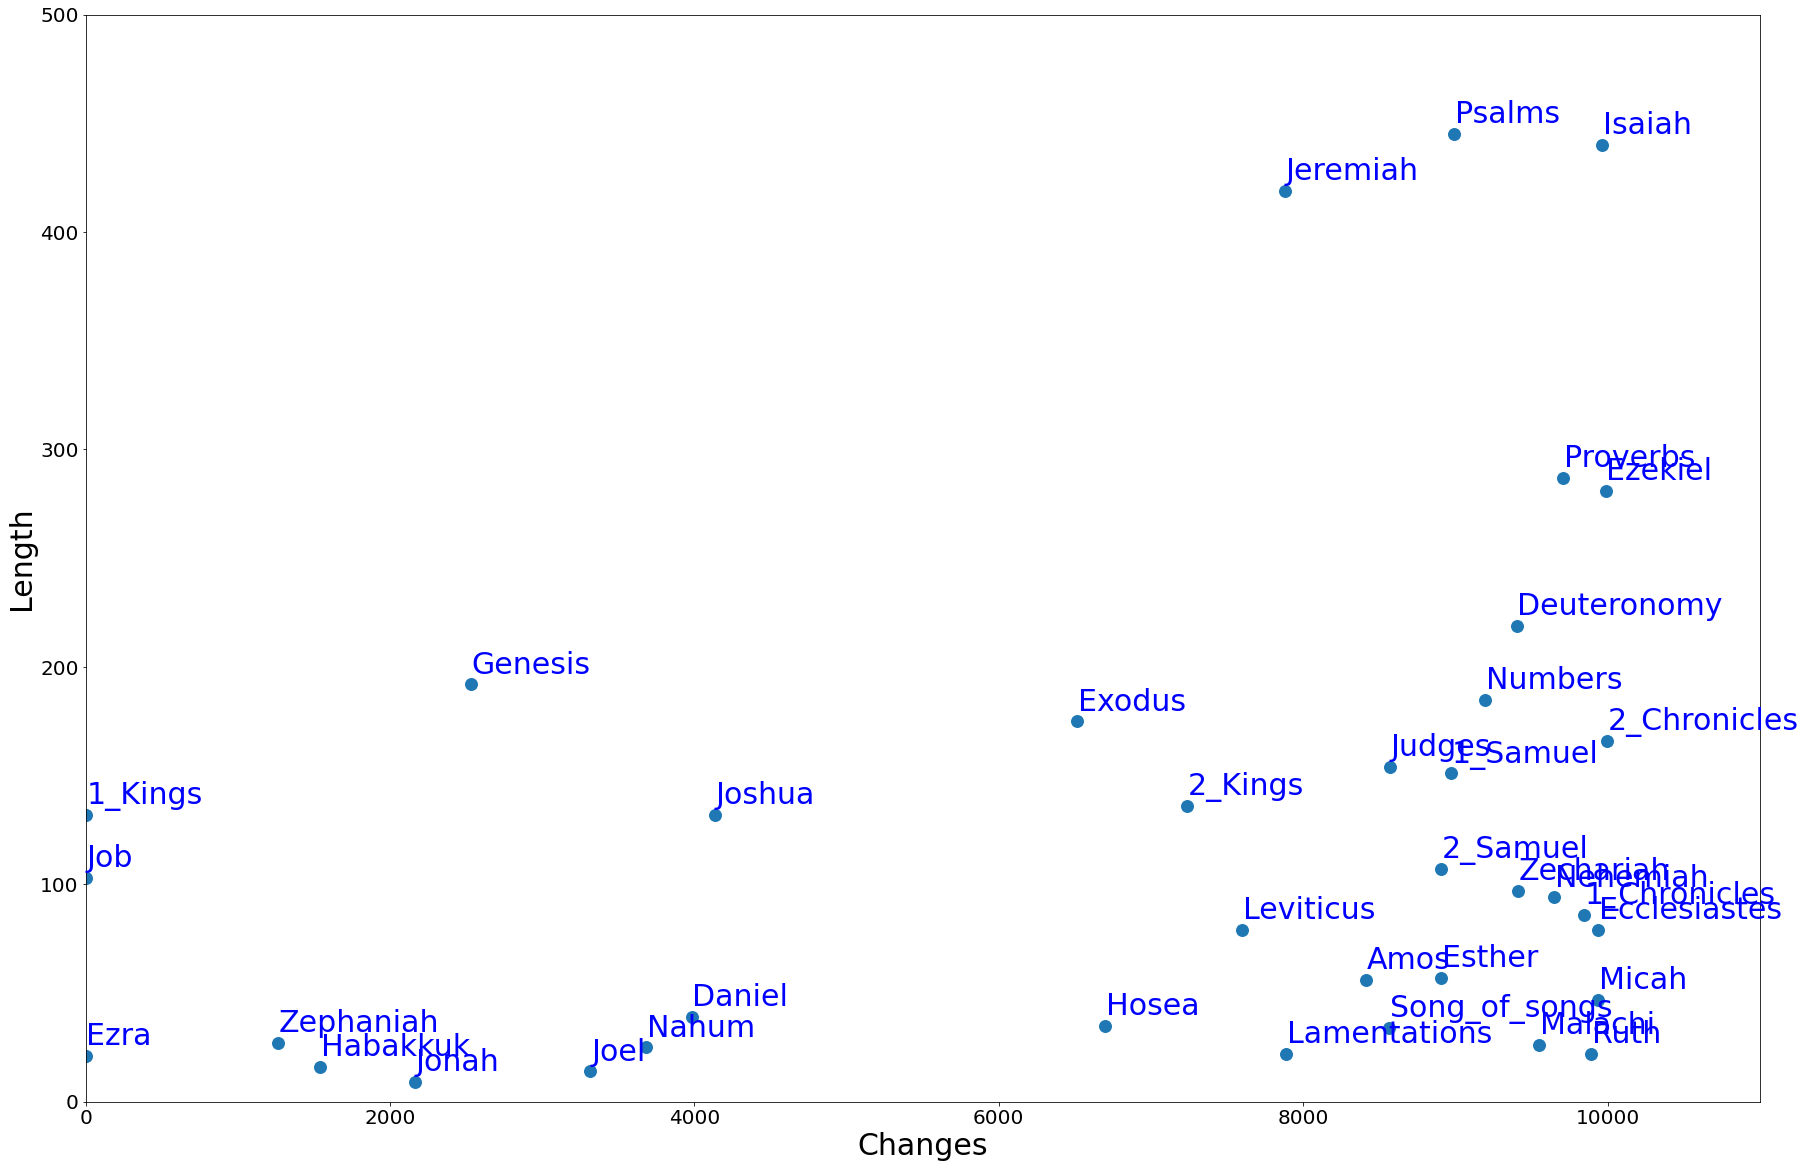

In [27]:
# Changes vs length

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(30,20))
plt.xlim([0, 11000])
plt.ylim([0, 500])

#ident = [0.0, 100000]
#plt.plot(ident,ident)

sns.scatterplot(data=change_df,
                x='larger_than_random_changes',
                y='length',
                s=200)

ax.grid(which='major')
plt.xlabel('Changes',size=30)
plt.ylabel('Length', size=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

for i in range(change_df.shape[0]):
    plt.text(x=change_df.larger_than_random_changes[i]+5,
             y=change_df.length[i]+5, 
             s=change_df.book[i], 
             fontdict=dict(color='blue',size=30)
            )

#plt.savefig(data_file.split('.')[0] + '_scatterplot.png')    
plt.show()

<Axes: xlabel='larger_than_random_changes', ylabel='length'>

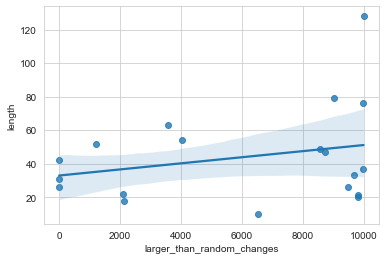

In [252]:
sns.regplot(data=df, 
            x='larger_than_random_changes',
            y='length',
            #order=2
           )

NameError: name 'df' is not defined

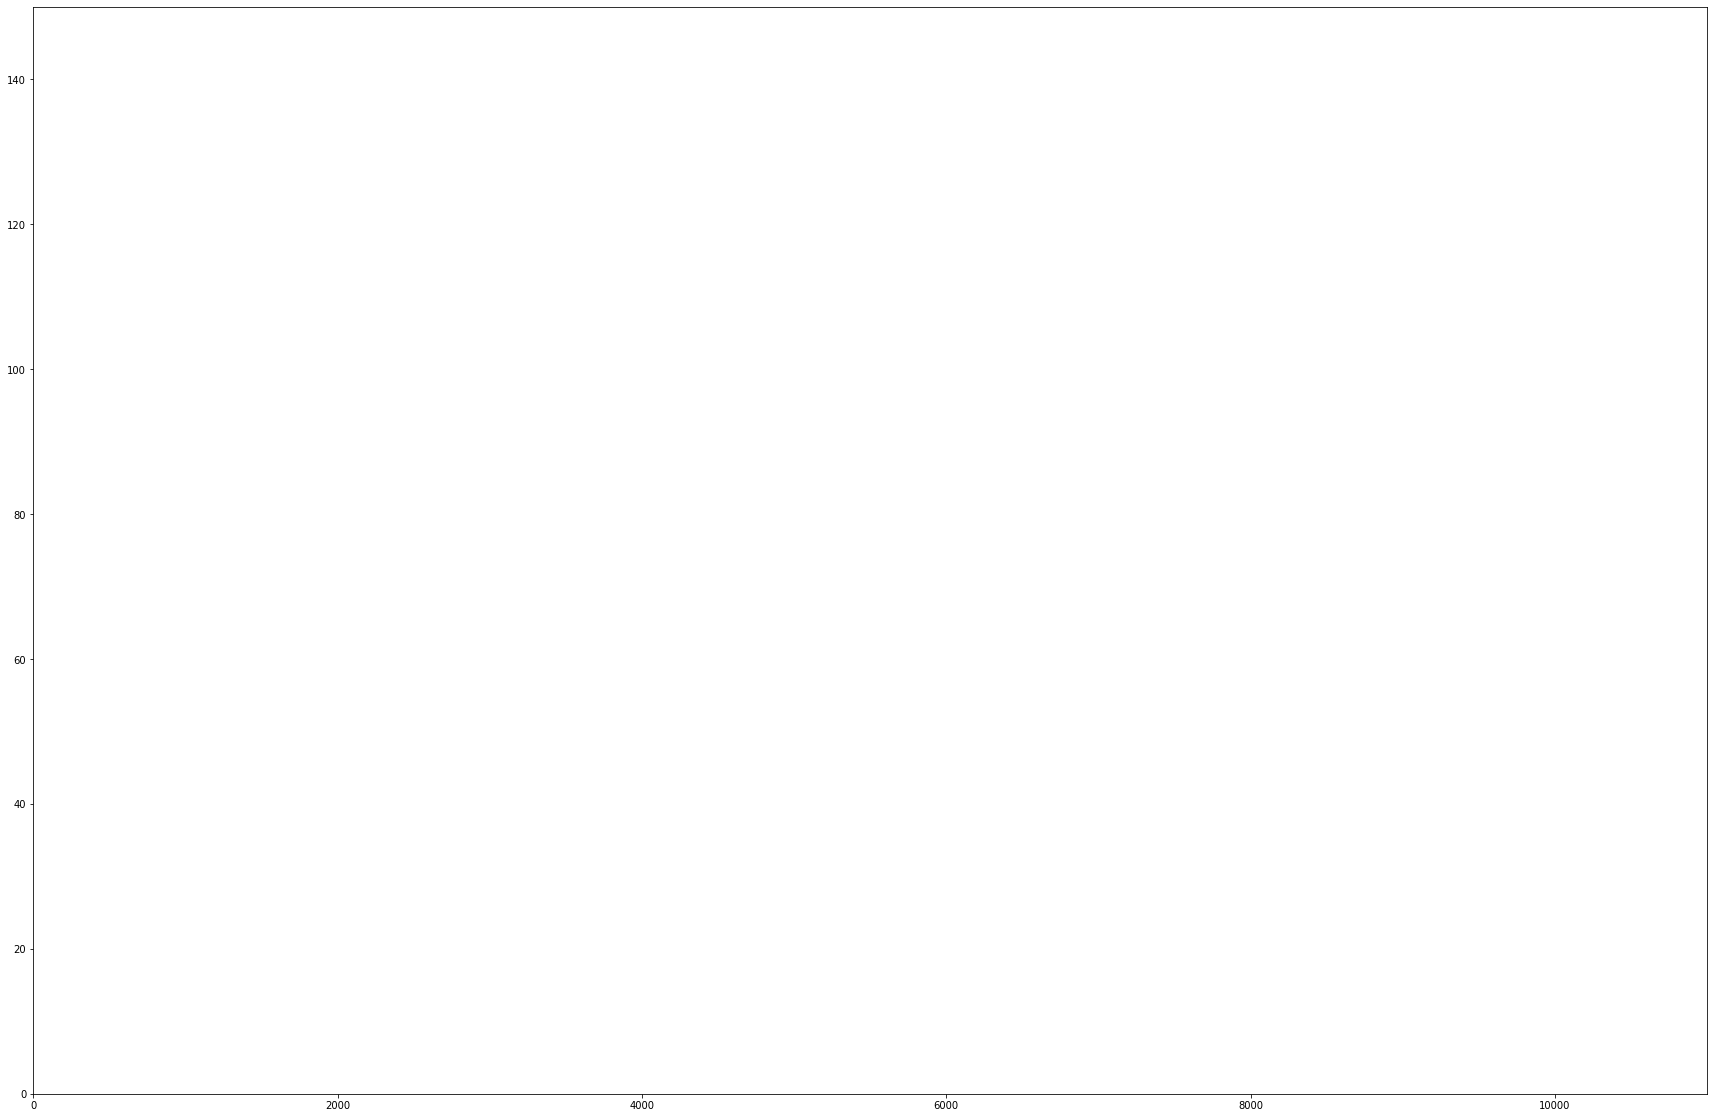

In [29]:
# Changes vs fullness-length interaction

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(30,20))
plt.xlim([0, 11000])
plt.ylim([0, 150])

#ident = [0.0, 100000]
#plt.plot(ident,ident)

sns.scatterplot(data=df,
                x='larger_than_random_changes',
                y='fullness_length_interaction',
                s=200)


ax.grid(which='major')
plt.xlabel('Changes',size=30)
plt.ylabel('Fullness * Length', size=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

for i in range(df.shape[0]):
    plt.text(x=df.larger_than_random_changes[i]+5,y=df.fullness_length_interaction[i]+5, s=df.book[i], 
            fontdict=dict(color='blue',size=30),
            #bbox=dict(facecolor='yellow',alpha=0.5)
            )

#plt.savefig(data_file.split('.')[0] + '_scatterplot.png')    
plt.show()

# EXAMPLE SEQS

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] 1 10000 8 8 0 9522
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] 15 0 8 8 14 0
[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0] 7 5972 8 8 4 3394
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1] 11 283 8 8 9 99
[0, 1, 0] 2 0 2 1 1 0
[0, 0, 0] 0 0 3 0 0 0


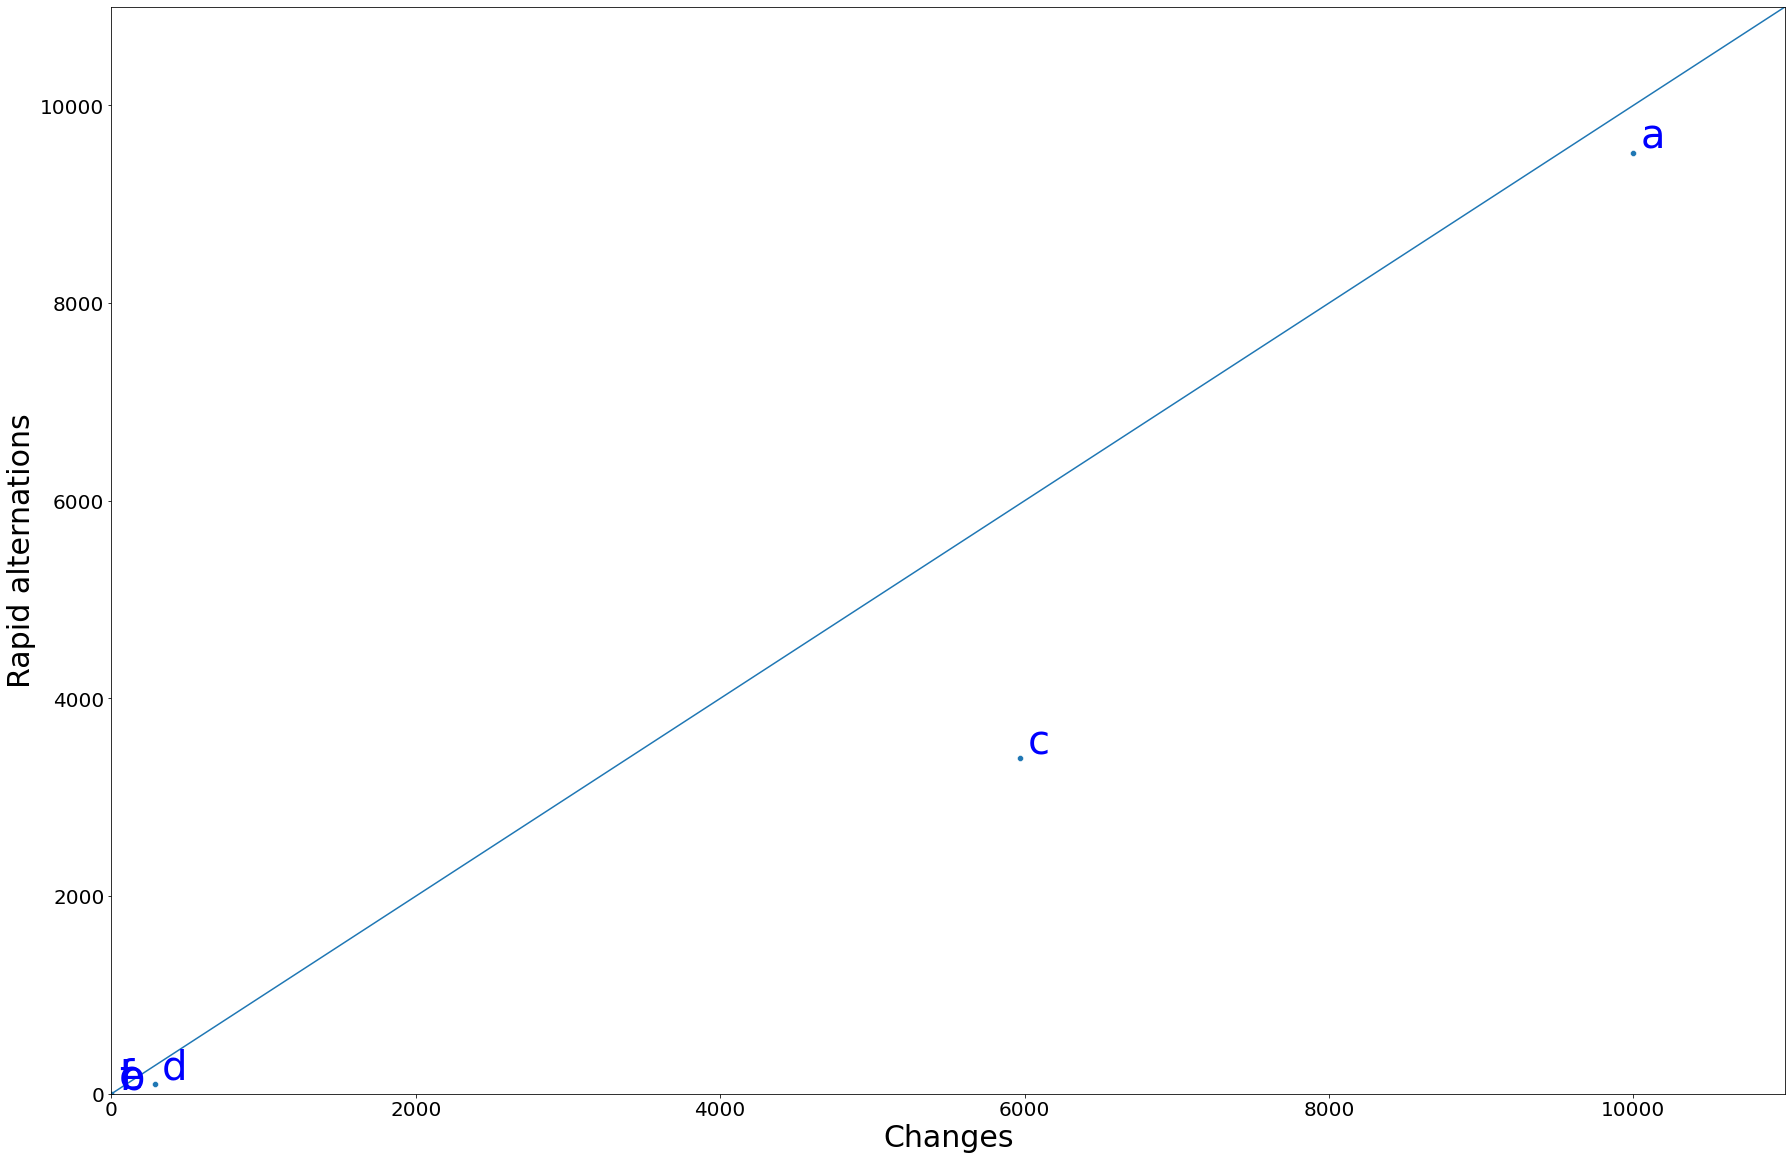

In [38]:
demo_dict = {
    'a': [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
    'b': [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1],
    'c': [1,1,1,1,0,1,0,1,0,0,1,1,0,0,0,0],
    'd': [0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,1],
    'e': [0,1,0],
    'f': [0,0,0]
}



num_samples = 10000

info_dict = {}


for book_name, book in demo_dict.items():
    zero_count = book.count(0)
    one_count = book.count(1)
    
    book_vl_copy = book.copy()
    book_samples_changes = make_all_samples_for_book_changes(num_samples, book_vl_copy)
    bigrams = make_n_grams(book, 2)
    num_changes_book = count_changes(bigrams)
    larger_than_book_changes = sum([1 if change > num_changes_book else 0 for change in book_samples_changes])
    
    book_samples_alternations = make_all_samples_for_book_alternations(num_samples, book_vl_copy)
    trigrams = make_n_grams(book, 3)
    num_alternations_book = count_alternations(trigrams)
    larger_than_book_alternations = sum([1 if alt > num_alternations_book else 0 for alt in book_samples_alternations])

    print(book, num_changes_book , larger_than_book_changes, zero_count, one_count, num_alternations_book, larger_than_book_alternations)
    
    info = {
        'book': book_name,
        'zero_count': zero_count,
        'one_count': one_count,
        'num_changes': num_changes_book,
        'larger_than_random_changes': larger_than_book_changes,
        'num_alternations': num_alternations_book,
        'larger_than_random_alternations': larger_than_book_alternations
    }
    info_dict[book_name] = info
    
df = pd.DataFrame(info_dict).T
df.columns

plt.figure(figsize=(30,20))
plt.xlim([0, 11000])
plt.ylim([0, 11000])

ident = [0.0, 100000]
plt.plot(ident,ident)

sns.scatterplot(data=df,x='larger_than_random_changes',y='larger_than_random_alternations')

plt.xlabel('Changes',size=30)
plt.ylabel('Rapid alternations', size=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

for i in range(df.shape[0]):
    plt.text(x=df.larger_than_random_changes[i]+50,y=df.larger_than_random_alternations[i]+50, s=df.book[i], 
             fontdict=dict(color='blue', size=40),
            )
    
plt.savefig('demo_scatterplot_example.png')
plt.show()

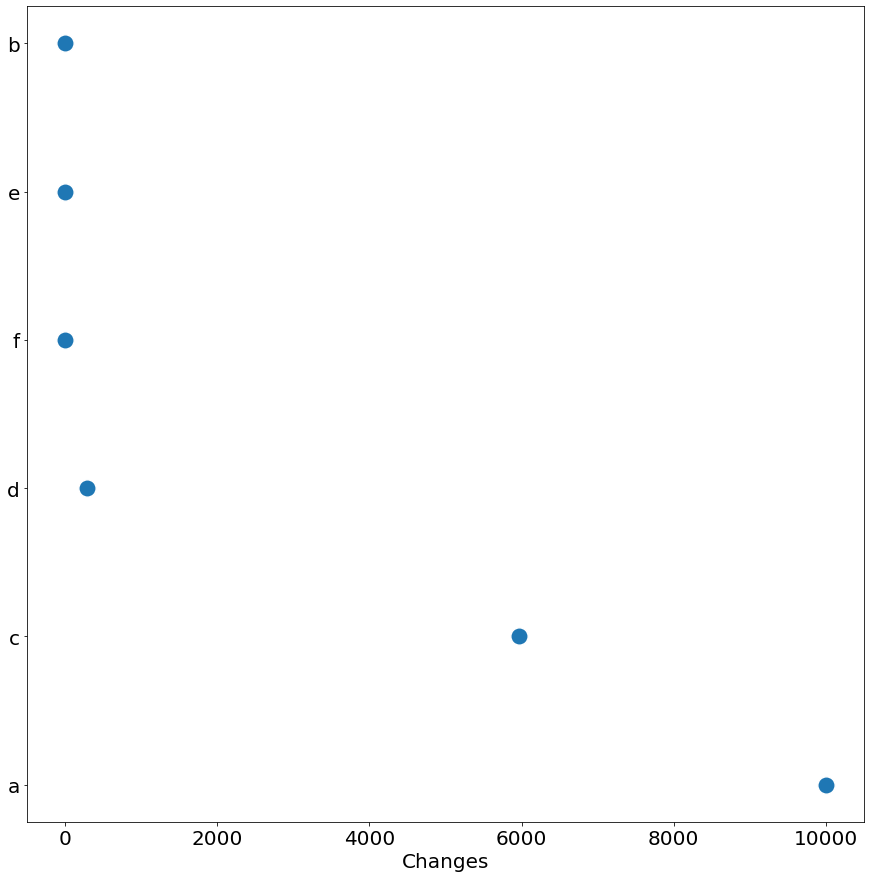

In [40]:
# ONLY CHANGES

fig, ax = plt.subplots(figsize=(15, 15))
sc = sns.scatterplot(data=df.sort_values(by='larger_than_random_changes'),
                     x='larger_than_random_changes',
                     y='book',
                     s=300,
                     legend=False,
                     ax=ax,
                    )

ax.grid(which='major')
sc.tick_params(labelsize=20)
sc.set_xlabel('Changes',fontsize=20)
sc.set_ylabel('',fontsize=20)

plt.savefig('example_seqs_dotplot.png') 
plt.show()

# EXAMPLE DISTRIBUTION

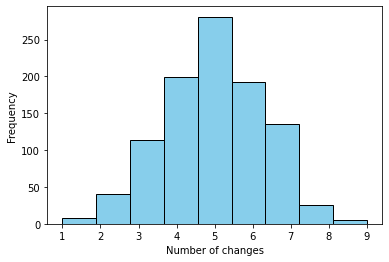

In [75]:
random.seed(42)

num_samples = 1000
spelling_sample = [1,1,1,1,1,0,0,0,0,0]
all_samples = make_all_samples_for_book_changes
(num_samples, spelling_sample)

plt.hist(all_samples, bins=9, color='skyblue', edgecolor='black')
plt.xlabel('Number of changes')
plt.ylabel('Frequency')

plt.savefig('changes_hist_example.png')
plt.show()


28


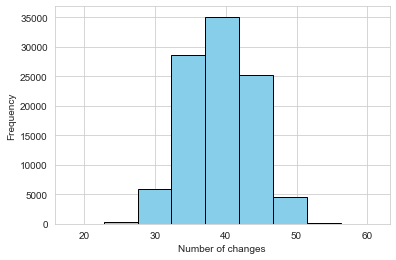

In [287]:
random.seed(42)

num_samples = 100000
book = 'Ecclesiastes'
book_data = mt[mt.book == book]
spelling_sample = list(book_data.has_vowel_letter)

bigrams = make_n_grams(spelling_sample, 2)  
num_changes_book = count_changes(bigrams)
print(num_changes_book)

all_samples = make_all_samples_for_book_changes(num_samples, spelling_sample)

plt.hist(all_samples, bins=9, color='skyblue', edgecolor='black')
plt.xlabel('Number of changes')
plt.ylabel('Frequency')

plt.savefig(f'{data_file}_{book}_changes_hist_example.png')
plt.show()



In [286]:
sum([1 if change > num_changes_book else 0 for change in all_samples])

99277

In [ ]:
book_samples_alternations = make_all_samples_for_book_alternations(num_samples, book_vl_copy)

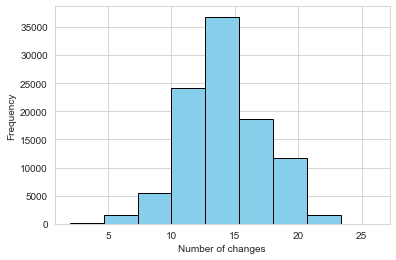

In [290]:
random.seed(42)

num_samples = 100000
book = 'Job'
book_data = mt[mt.book == book]
spelling_sample = list(book_data.has_vowel_letter)

all_samples = make_all_samples_for_book_alternations(num_samples, spelling_sample)

plt.hist(all_samples, bins=9, color='skyblue', edgecolor='black')
plt.xlabel('Number of changes')
plt.ylabel('Frequency')

#plt.savefig('changes_hist_example.png')
plt.show()